# Интерпретация моделей с помощью LIME и SHAP

* [SHAP](https://habr.com/ru/post/428213/)
* [LIME](https://habr.com/ru/company/ods/blog/599573/#2)

In [1]:
import pandas as pd
import numpy as np

# No warnings about setting value on copy of slice
pd.options.mode.chained_assignment = None
pd.set_option('display.max_columns', 60)

import matplotlib.pyplot as plt
%matplotlib inline

# Set default font size
plt.rcParams['font.size'] = 24

from IPython.core.pylabtools import figsize

# Seaborn for visualization
import seaborn as sns

sns.set(font_scale = 2)

# Imputing missing values
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import SimpleImputer

# Machine Learning Models
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor

from sklearn import tree

In [2]:
!pip install lime

In [3]:
# LIME for explaining predictions
import lime 
import lime.lime_tabular

### Загружаем данные

По имеющимся данным об энергоэффективности зданий в Нью-Йорке  построиит модель, которая прогнозирует количество баллов Energy Star Score для конкретного здания, и интерпретировать результаты для поиска факторов, влияющих на итоговый балл.

In [4]:
# Read in data into dataframes 
train_features = pd.read_csv("training_features.csv")
test_features = pd.read_csv("testing_features.csv")
train_labels = pd.read_csv("training_labels.csv")
test_labels = pd.read_csv("testing_labels.csv")

In [5]:
train_features.head()

Order  Property Id  DOF Gross Floor Area  Year Built  \
0  13276      5849784               90300.0        1950   
1   7377      4398442               52000.0        1926   
2   9479      4665374              104700.0        1954   
3  14774      3393340              129333.0        1992   
4   3286      2704325              109896.0        1927   

   Number of Buildings - Self-reported  Occupancy  Site EUI (kBtu/ft²)  \
0                                    1        100                126.0   
1                                    1        100                 95.4   
2                                    1        100                 40.4   
3                                    1        100                157.1   
4                                    1        100                 62.3   

   Weather Normalized Site Electricity Intensity (kWh/ft²)  \
0                                                5.2         
1                                                4.7         
2                                                3.8         
3                                               16.9         
4                                                3.5         

   Weather Normalized Site Natural Gas Intensity (therms/ft²)  \
0                                                1.2            
1                                                0.9            
2                                                0.3            
3                                                1.1            
4                                                0.0            

   Water Intensity (All Water Sources) (gal/ft²)   Latitude  Longitude  \
0                                          99.41        NaN        NaN   
1                                            NaN  40.835496 -73.887745   
2                                            NaN  40.663206 -73.949469   
3                                            NaN  40.622968 -74.078742   
4                                          28.65  40.782421 -73.972622   

   Community Board  Census Tract  log_Direct GHG Emissions (Metric Tons CO2e)  \
0              NaN           NaN                                     6.088818   
1              3.0         161.0                                     5.384036   
2              9.0         329.0                                     5.017280   
3              1.0          27.0                                     6.510853   
4              7.0         165.0                                     6.123589   

   log_Water Intensity (All Water Sources) (gal/ft²)  Borough_Staten Island  \
0                                           4.599253                      0   
1                                                NaN                      0   
2                                                NaN                      0   
3                                                NaN                      1   
4                                           3.355153                      0   

   Largest Property Use Type_Adult Education  \
0                                          0   
1                                          0   
2                                          0   
3                                          0   
4                                          0   

   Largest Property Use Type_Automobile Dealership  \
0                                                0   
1                                                0   
2                                                0   
3                                                0   
4                                                0   

   Largest Property Use Type_Bank Branch  \
0                                      0   
1                                      0   
2                                      0   
3                                      0   
4                                      0   

   Largest Property Use Type_College/University  \
0                                             0   
1                                             0   


## Используем модель с уже найденными гиперпараметрами

In [6]:
# Create an imputer object with a median filling strategy
imputer = SimpleImputer(strategy='median')

# Train on the training features
imputer.fit(train_features)

# Transform both training data and testing data
X = imputer.transform(train_features)
X_test = imputer.transform(test_features)

# Sklearn wants the labels as one-dimensional vectors
y = np.array(train_labels).reshape((-1,))
y_test = np.array(test_labels).reshape((-1,))

In [7]:
# Function to calculate mean absolute error
def mae(y_true, y_pred):
    return np.mean(abs(y_true - y_pred))

In [8]:
model = GradientBoostingRegressor(max_depth=5, max_features=None,
                                  min_samples_leaf=6, min_samples_split=6, 
                                  n_estimators=800, random_state=42)

model.fit(X, y)

GradientBoostingRegressor(max_depth=5, min_samples_leaf=6, min_samples_split=6,
                          n_estimators=800, random_state=42)

In [9]:
#  Make predictions on the test set
model_pred = model.predict(X_test)

print('Final Model Performance on the test set: MAE = %0.4f' % mae(y_test, model_pred))

Final Model Performance on the test set: MAE = 9.4122


# Интерпретация модели

Встроенные в деревянные модели методы feature_importance_ показывают важность признаков для модели, но не показывают, какой вклад вносят признаки в ответ. 

Для некоторых моделей даже нет базового готового решения, как посчитать важность (например, для KNN).

In [10]:
# Extract the feature importances into a dataframe
feature_results = pd.DataFrame({'feature': list(train_features.columns), 
                                'importance': model.feature_importances_})

# Show the top 10 most important
feature_results = feature_results.sort_values('importance', ascending = False).reset_index(drop=True)

feature_results.head(10)

feature  importance
0                                Site EUI (kBtu/ft²)    0.605408
1  Weather Normalized Site Electricity Intensity ...    0.140072
2      Largest Property Use Type_Multifamily Housing    0.074995
3                                        Property Id    0.026007
4                               DOF Gross Floor Area    0.018150
5        log_Direct GHG Emissions (Metric Tons CO2e)    0.017216
6                                              Order    0.015234
7  Largest Property Use Type_Non-Refrigerated War...    0.013548
8                                         Year Built    0.013509
9                                          Longitude    0.010917

Самые важные признаки:
* `Site EUI (kBtu/ft²)`
* Weather Normalized Site Electricity Intensity, `Weather Normalized Site Electricity Intensity (kWh/ft²)` 

Нарисуем важность признаков.

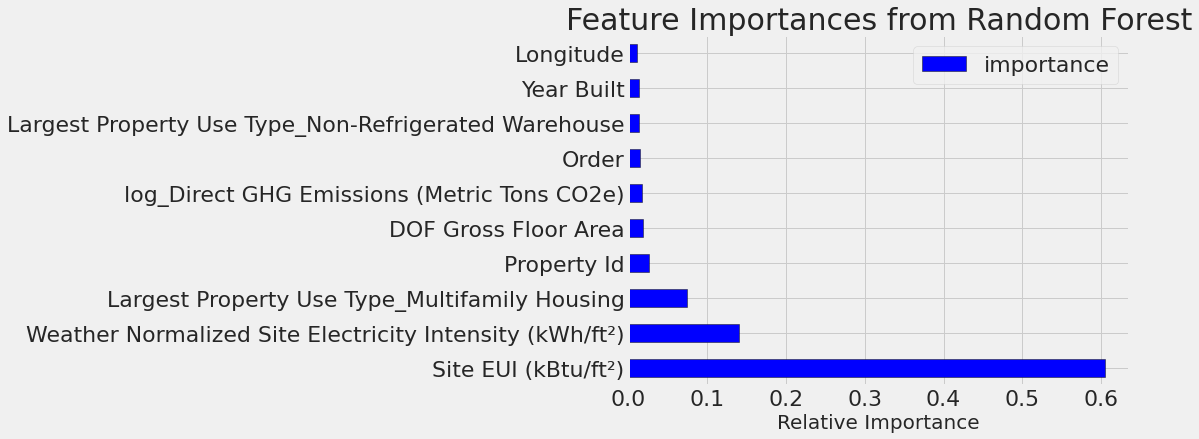

In [25]:
figsize(8, 6)
plt.style.use('fivethirtyeight')

# Plot the 10 most important features in a horizontal bar chart
feature_results.loc[:9, :].plot(x = 'feature', y = 'importance', 
                                 edgecolor = 'k',
                                 kind='barh', color = 'blue');
plt.xlabel('Relative Importance', size = 20); plt.ylabel('')
plt.title('Feature Importances from Random Forest', size = 30);

## Отбор признаков по feature importances

Попробуем выбросить признаки с маленькой важностью.


In [26]:
# Extract the names of the most important features
most_important_features = feature_results['feature'][:10]

# Find the index that corresponds to each feature name
indices = [list(train_features.columns).index(x) for x in most_important_features]

# Keep only the most important features
X_reduced = X[:, indices]
X_test_reduced = X_test[:, indices]

print('Most important training features shape: ', X_reduced.shape)
print('Most important testing  features shape: ', X_test_reduced.shape)

Most important training features shape:  (6622, 10)
Most important testing  features shape:  (2839, 10)


In [27]:
lr = LinearRegression()

# Fit on full set of features
lr.fit(X, y)
lr_full_pred = lr.predict(X_test)

# Fit on reduced set of features
lr.fit(X_reduced, y)
lr_reduced_pred = lr.predict(X_test_reduced)

# Display results
print('Linear Regression Full Results: MAE =    %0.4f.' % mae(y_test, lr_full_pred))
print('Linear Regression Reduced Results: MAE = %0.4f.' % mae(y_test, lr_reduced_pred))

Linear Regression Full Results: MAE =    13.4651.
Linear Regression Reduced Results: MAE = 14.3338.


Видим, что для линейной модели всё же важны признаки, имеющие маленький вес по мнению бустинга.

In [28]:
# Create the model with the same hyperparamters
model_reduced = GradientBoostingRegressor(max_depth=5, max_features=None,
                                  min_samples_leaf=6, min_samples_split=6, 
                                  n_estimators=800, random_state=42)

# Fit and test on the reduced set of features
model_reduced.fit(X_reduced, y)
model_reduced_pred = model_reduced.predict(X_test_reduced)

print('Gradient Boosted Reduced Results: MAE = %0.4f' % mae(y_test, model_reduced_pred))

Gradient Boosted Reduced Results: MAE = 9.9360


Качество бустинга немного ухудшилось, поэтому для итоговой модели не стоит выкидывать признаки таким образом.

Но с целью интерпретируемости нас интересует максимально простая модель. Давайте дальше анализировать модель, обученную на 10 самых важных признаках.

## Locally Interpretable Model-agnostic Explanations (LIME)

[Ещё одна интересная статья.](https://towardsdatascience.com/lime-explain-machine-learning-predictions-af8f18189bfe)

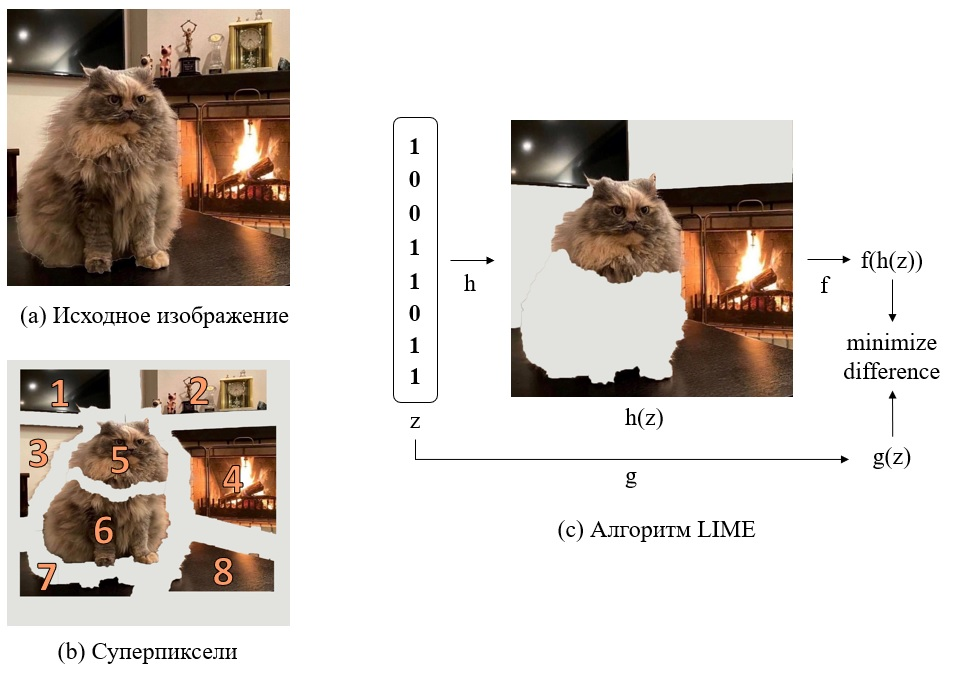

Проанализируем модель на примере с очень плохим предсказанием (а потом - с очень хорошим).

In [29]:
# Find the residuals
residuals = abs(model_reduced_pred - y_test)
    
# Exact the worst and best prediction
wrong = X_test_reduced[np.argmax(residuals), :]
right = X_test_reduced[np.argmin(residuals), :]

In [30]:
np.argmax(residuals), np.argmin(residuals)

(1023, 1770)

In [31]:
# Create a lime explainer object
explainer = lime.lime_tabular.LimeTabularExplainer(training_data = X_reduced, 
                                                   mode = 'regression',
                                                   training_labels = y,
                                                   feature_names = list(most_important_features))

Prediction: 23.5283
Actual Value: 100.0000


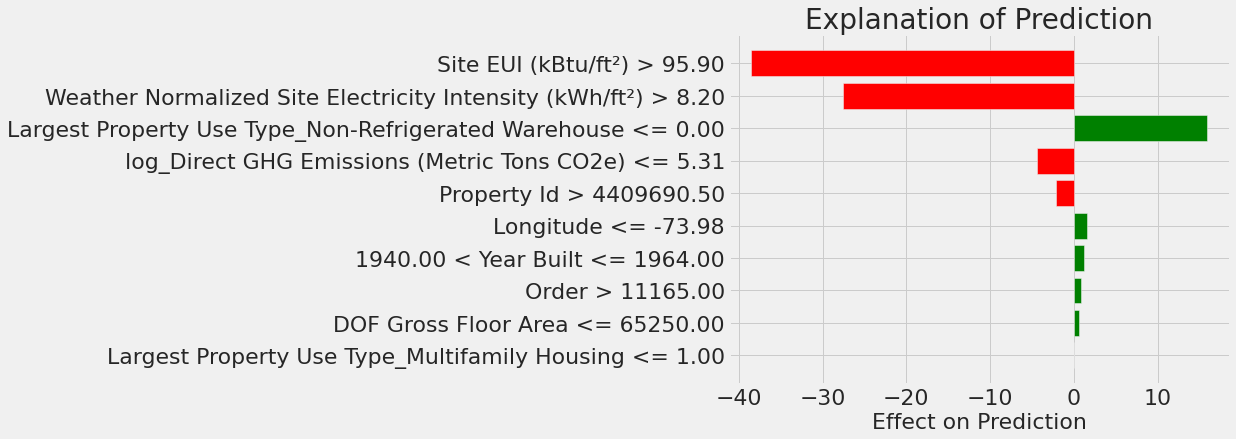

In [32]:
# Display the predicted and true value for the wrong instance
print('Prediction: %0.4f' % model_reduced.predict(wrong.reshape(1, -1)))
print('Actual Value: %0.4f' % y_test[np.argmax(residuals)])

# Explanation for wrong prediction
wrong_exp = explainer.explain_instance(data_row = wrong, 
                                       predict_fn = model_reduced.predict)

# Plot the prediction explaination
wrong_exp.as_pyplot_figure();
plt.title('Explanation of Prediction', size = 28);
plt.xlabel('Effect on Prediction', size = 22);

* EUI (Energy Use Intensity, интенсивность использования энергии) — это количество энергии, потреблённой зданием, делённое на квадратный фут площади. Эта удельная величина используется для оценки энергоэффективности, и чем она меньше, тем лучше.

In [ ]:
wrong_exp.show_in_notebook(show_predicted_value=False)

Проанализируем модель на примере с корректным предсказанием.

Prediction: 100.0000
Actual Value: 100.0000


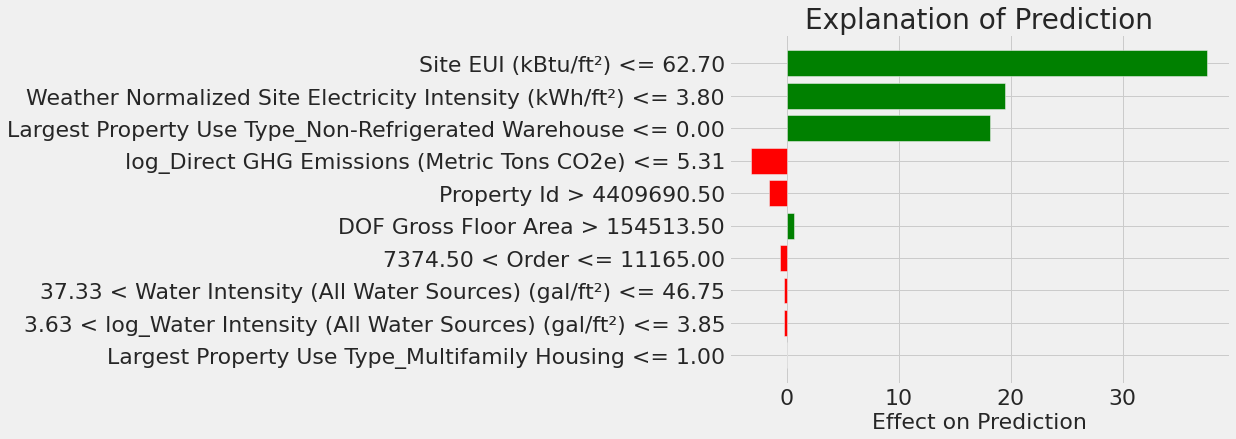

In [ ]:
# Display the predicted and true value for the wrong instance
print('Prediction: %0.4f' % model_reduced.predict(right.reshape(1, -1)))
print('Actual Value: %0.4f' % y_test[np.argmin(residuals)])

# Explanation for wrong prediction
right_exp = explainer.explain_instance(right, model_reduced.predict, num_features=10)
right_exp.as_pyplot_figure();
plt.title('Explanation of Prediction', size = 28);
plt.xlabel('Effect on Prediction', size = 22);

In [ ]:
right_exp.show_in_notebook(show_predicted_value=False)

## SHAP

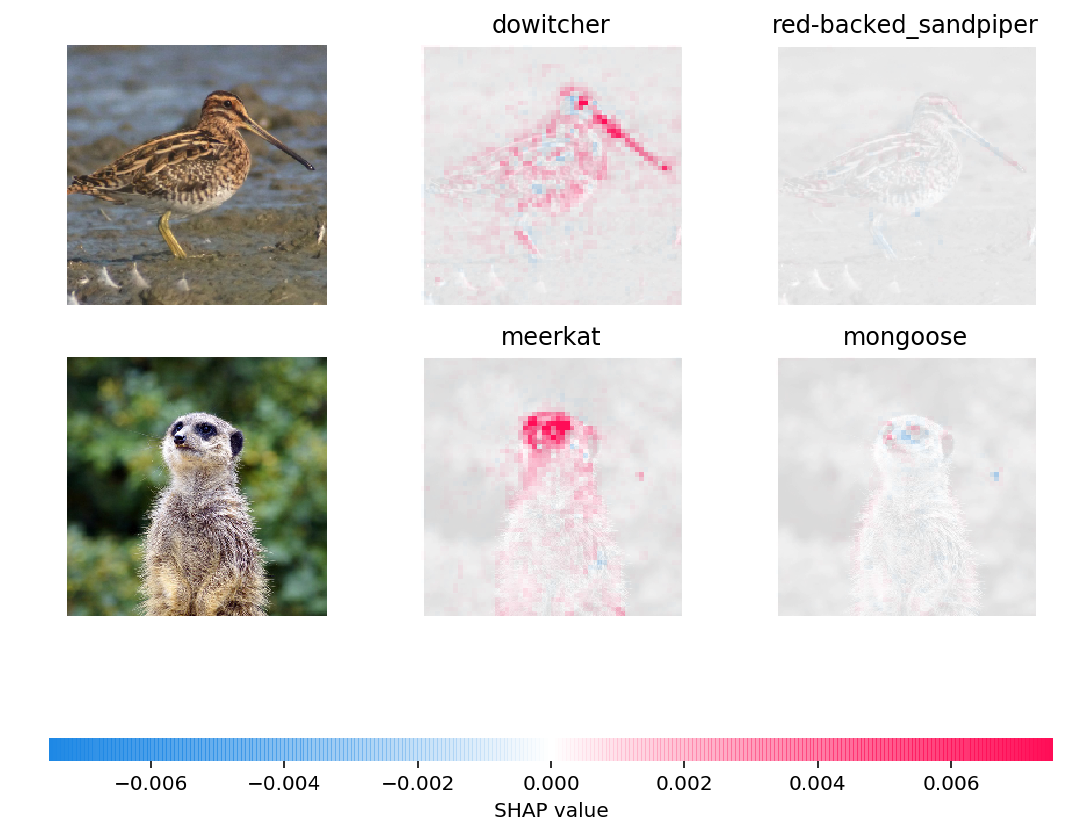

In [ ]:
!pip install shap

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 575.9/575.9 KB 14.6 MB/s eta 0:00:00


In [ ]:
import shap
shap.initjs()

In [ ]:
gb_explainer = shap.KernelExplainer(model_reduced.predict, X_test_reduced[1000:1100])
gb_shap_values = gb_explainer.shap_values(X_test_reduced[1000:1100])

  0%|          | 0/100 [00:00<?, ?it/s]

In [ ]:
shap.initjs()
shap.force_plot(gb_explainer.expected_value, gb_shap_values[23,:], X_test_reduced[23,:], 
                feature_names = list(most_important_features))

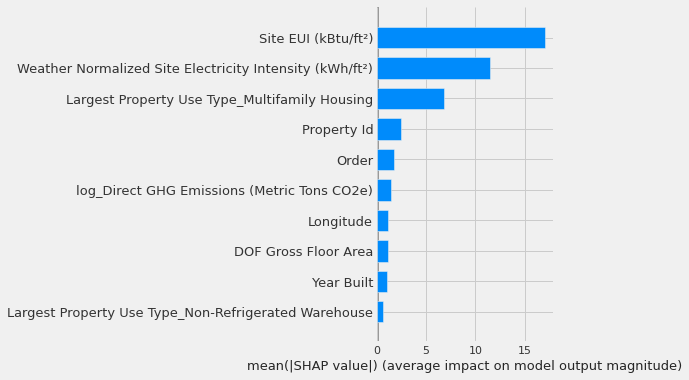

In [ ]:
shap.summary_plot(gb_shap_values, X_test_reduced[1000:1100], plot_type="bar", feature_names = list(most_important_features))

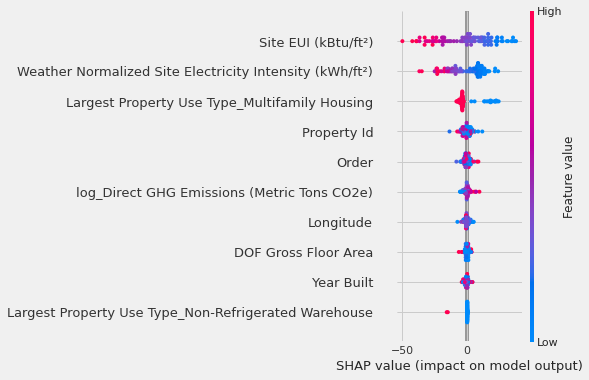

In [ ]:
shap.summary_plot(gb_shap_values, X_test_reduced[1000:1100], feature_names = list(most_important_features))

In [ ]:
shap.initjs()
shap.force_plot(gb_explainer.expected_value, gb_shap_values, X_test_reduced[1000:1100])